# Test the prediction


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for distance between probability distributions
from scipy.stats import wasserstein_distance

sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})




## Load the data and the inferred transition matrix

In [6]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [7]:
# load the inferred transition matrix
P_allCountries_Bayes = np.genfromtxt('./../results/transitionBayesAllCountries.csv')

## Look at prediction starting from different years

In [21]:
## Functions


def computeWassersteinDistances(historicDistribitionsIn,predictedDistributions):
    nSamples = historicDistribitionsIn.shape[1]
    wassersteinDistances = []
    
    for i in np.arange(nSamples):
        WD = wasserstein_distance(historicDistribitionsIn[:,i],predictedDistributions[:,i])
        wassersteinDistances.append(WD)

    return(np.array(wassersteinDistances))

def distributionsForYear(timeSeriesData,year):
    currentScores=timeSeriesData[timeSeriesData['year']==year]['polity2']
    [countsYear,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
    densityYear = countsYear/np.sum(countsYear)
    return(densityYear)

def predictionFromYearFixed(data,year,yearsInFuture):
    # subset the data
    data = data[data['year']<=year]
    # compute the starting distirbutions
    x=np.zeros((21,yearsInFuture))
    x[:,0]=distributionsForYear(data,year)
    #  compute the transitions
    for t in np.arange(yearsInFuture-1):
        x[:,t+1]= x[:,t].dot(P_allCountries_Bayes)
        
    return(x)


def calculateWasserstein(timeSeries,year,predictionMethod='markov'):
    
    # calculate the distribution for the future years
    # compare with actual development
    yearsHistoric = np.arange(year,2018,1)
    historicDistributions = np.zeros((21,len(yearsHistoric)))
    i=0
    for y in yearsHistoric:
        historicDistributions[:,i] = distributionsForYear(timeSeries,y)
        i=i+1
    # do the prediction
    if predictionMethod == 'markov':
        # do the prediction
        yearInFuture = 2018-year
        xYear = predictionFromYearFixed(timeSeries,year,yearInFuture)
        # # summarise
        error = computeWassersteinDistances(historicDistributions,xYear)
    if predictionMethod == 'random':
        xYearRandom = np.zeros((21,len(yearsHistoric)))
        i=0
        for y in yearsHistoric:
            randDistribution = np.random.rand(21)
            xYearRandom[:,i] = randDistribution/np.sum(randDistribution)
            i=i+1
        # # summarise
        error = computeWassersteinDistances(historicDistributions,xYearRandom)
    if predictionMethod == 'uniform':
        xYearUniform = np.zeros((21,len(yearsHistoric)))
        i=0
        for y in yearsHistoric:
            uniformDistribution = np.ones(21)
            xYearUniform[:,i] = uniformDistribution/np.sum(uniformDistribution)
            i=i+1
        # # summarise
        error = computeWassersteinDistances(historicDistributions,xYearUniform)
    if predictionMethod == 'EoH':
        xYearEoH = np.zeros((21,len(yearsHistoric)))
        i=0
        for y in yearsHistoric:
            onlyFullDemocracies = np.zeros(21)
            onlyFullDemocracies[20] = 1
            xYearEoH[:,i] = onlyFullDemocracies
            i=i+1
        # # summarise
        error = computeWassersteinDistances(historicDistributions,xYearEoH)
        
    return(error)

In [22]:
# average this for all years 1900 until 2000


yearsInFuture=120


yearVec = np.arange(1800,2018-yearsInFuture)
nYear = len(yearVec)

# save the error for 30 years in future
errorOutMarkov = np.empty((nYear,yearsInFuture))
errorOutMarkov[:] = np.NaN
errorOutRand = np.empty((nYear,yearsInFuture))
errorOutRand[:] = np.NaN
errorOutUniform = np.empty((nYear,yearsInFuture))
errorOutUniform[:] = np.NaN
errorOutEoH = np.empty((nYear,yearsInFuture))
errorOutEoH[:] = np.NaN


i=0
for year in yearVec:
    yearInFutureAdjusted = np.min([2018 - year,yearsInFuture])
    
    #print('year ',year)

    errorMarkov = calculateWasserstein(timeSeries,year,predictionMethod = 'markov')
    errorRandom = calculateWasserstein(timeSeries,year,predictionMethod = 'random')
    errorUniform = calculateWasserstein(timeSeries,year,predictionMethod = 'uniform')
    errorEoH = calculateWasserstein(timeSeries,year,predictionMethod = 'EoH')
    
    errorOutMarkov[i,0:yearInFutureAdjusted] =  errorMarkov[0:yearInFutureAdjusted]
    errorOutRand[i,0:yearInFutureAdjusted] =  errorRandom[0:yearInFutureAdjusted]
    errorOutUniform[i,0:yearInFutureAdjusted] =  errorUniform[0:yearInFutureAdjusted]
    errorOutEoH[i,0:yearInFutureAdjusted] =  errorEoH[0:yearInFutureAdjusted]
    
    
    i=i+1

### Plotting

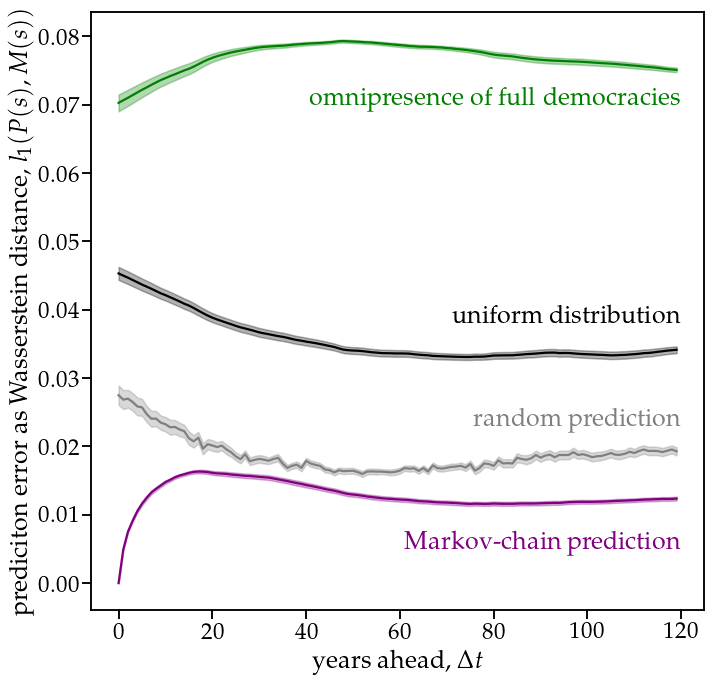

In [39]:
def plotWithErrorShade(y,color='k'):
    
    n = y.shape[0]
    
    mean = np.nanmean(y,axis=0)
    std = np.nanstd(y,axis=0)/np.sqrt(n)
    x = np.arange(0,len(mean))
    
    plt.plot(x, mean, '-',color=color)
    #plt.fill_between(x, mean-std, mean+std, "b",alpha=0.3)
    plt.fill_between(x, mean-std, mean+std,alpha=0.3,color=color)

plt.figure(figsize=(11,11))  
plotWithErrorShade(errorOutMarkov,color='purple')
plotWithErrorShade(errorOutRand,color='grey')
plotWithErrorShade(errorOutEoH,color='green')
plotWithErrorShade(errorOutUniform,color='black')


# plt.legend(['Markov-chain prediction','stationary prediction','omnipresence of full democracies'])
# plt.legend(['Markov-chain prediction','stationary prediction','random prediction'])

#plt.yscale('log')
#plt.xscale('log')



### Text labesl
plt.text(x=120,y=0.07,s='omnipresence of full democracies',color='green',ha='right')
plt.text(x=120,y=0.038,s='uniform distribution',color='black',ha='right')
plt.text(x=120,y=0.023,s='random prediction',color='grey',ha='right')

plt.text(x=120,y=0.005,s='Markov-chain prediction',color='purple',ha='right')

# plt.text(x=30,y=0.025,s='Markov-chain prediction',color='purple')
# plt.text(x=35,y=0.07,s='stationary prediction',color='orange')


plt.ylabel(r'prediciton error as Wasserstein distance, $l_1(P(s),M(s))$')
plt.xlabel(r'years ahead, $\Delta t$')
#plt.savefig('./figures/predictionRMSE_v2.pdf')
plt.savefig('./../results/figures/Fig7-predictionError.pdf',bbox_inches='tight')



In [16]:
errorOutMarkovRecalc

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [8]:

# def estimateTransitionMatrix(data,approach='frequentist'):
    
#     # construct some output matrices
#     countMatrix=np.zeros((21,21)) # empty transition matrix
    
#     # split the timeseries into one for each country 
#     uniqueCountries = data['country'].unique()
#     countryTimeseries =[]
    
#     # count for each country the transitions
#     for country in uniqueCountries:
#         sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity2"].tolist()
#         T=len(sortedPolity2Country)# number of data points
#         for t in range(T-1): # go over all years
#             fromTransition = int(sortedPolity2Country[t] + 10)
#             toTransition = int(sortedPolity2Country[t+1] + 10)
            
#             if  (fromTransition>=0) and ((toTransition>=0)):
                
#                 # increase the count for this year
#                 countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
#     if approach=='frequentist':
#         # compute the transition probabilities as count over total outgoing
#         P = countMatrix/countMatrix.sum(axis=1)[:,None]
#     if approach=='bayesian':
#         # we use a Dirichlet prior for each row
#         priorMatrix = np.zeros((21,21)) + 1/21
#         combinedMatrix = countMatrix + priorMatrix
#         # this is the posterior mean
#         P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
#     return(P)

In [28]:
# def distributionsForYear(timeSeriesData,year):
#     currentScores=timeSeriesData[timeSeriesData['year']==year]['polity2']
#     [countsYear,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
#     densityYear = countsYear/np.sum(countsYear)
#     return(densityYear)

# def predictionFromYear(data,year,yearsInFuture):
#     # subset the data
#     data = data[data['year']<=year]
#     # estimate transition matrix
#     P_temp = estimateTransitionMatrix(data,approach='bayesian')
#     # compute the starting distirbutions
#     x=np.zeros((21,yearsInFuture))
#     x[:,0]=distributionsForYear(data,year)
#     #  compute the transitions
#     for t in np.arange(yearsInFuture-1):
#         x[:,t+1]= x[:,t].dot(P_temp)
        
#     return(x)

# def summariseStates(x):
#     autocraty = np.sum(x[0:10,:],axis=0)
#     fullDemocracy = x[20,:]
#     partialDemocracy = np.sum(x[10:19,:],axis=0)
    
#     return([autocraty,fullDemocracy,partialDemocracy])

# def calculateRMSE(timeSeries,year,predictionMethod='markov'):
    
#     # calculate the distribution for the future years
#     # compare with actual development
#     yearsHistoric = np.arange(year,2018,1)
#     historicDistributions = np.zeros((21,len(yearsHistoric)))
#     i=0
#     for y in yearsHistoric:
#         historicDistributions[:,i] = distributionsForYear(timeSeries,y)
#         i=i+1
        
        
#     # do the prediction 
#     if predictionMethod == 'markov':
#         # do the prediction
#         yearInFuture = 2018-year
#         xYear = predictionFromYear(timeSeries,year,yearInFuture)
#         # summarise
#         errorMatrix = (historicDistributions-xYear)**2
#         error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
#     if predictionMethod == 'stationary':
#         xYearStationary = np.zeros((21,len(yearsHistoric)))
#         i=0
#         for y in yearsHistoric:
#             xYearStationary[:,i] = historicDistributions[:,0]
#             i=i+1
#         # summarise
#         errorMatrix = (historicDistributions-xYearStationary)**2
#         error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
#     if predictionMethod == 'uniform':
#         xYearUniform = np.zeros((21,len(yearsHistoric)))
#         i=0
#         for y in yearsHistoric:
#             uniformDistribution = np.ones(21)
#             xYearUniform[:,i] = uniformDistribution/np.sum(uniformDistribution)
#             i=i+1
#         # summarise
#         errorMatrix = (historicDistributions-xYearUniform)**2
#         error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
#     if predictionMethod == 'EoH':
#         xYearEoH = np.zeros((21,len(yearsHistoric)))
#         i=0
#         for y in yearsHistoric:
#             onlyFullDemocracies = np.zeros(21)
#             onlyFullDemocracies[20] = 1
#             xYearEoH[:,i] = onlyFullDemocracies
#             i=i+1
#         # summarise
#         errorMatrix = (historicDistributions-xYearEoH)**2
#         error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
        
#     return(error)

In [29]:
# # average this for all years 1900 until 2000
# yearsInFuture=75

# maxYear = 2018-yearsInFuture
# yearVec = np.arange(1850,maxYear)
# nYear = len(yearVec)




# # save the error for 30 years in future
# errorOut = np.empty((nYear,yearsInFuture))
# errorOut[:] = np.NaN
# errorOutStationary = np.empty((nYear,yearsInFuture))
# errorOutStationary[:] = np.NaN
# errorOutUniform = np.empty((nYear,yearsInFuture))
# errorOutUniform[:] = np.NaN
# errorOutEoH = np.empty((nYear,yearsInFuture))
# errorOutEoH[:] = np.NaN


# i=0
# for year in yearVec:
#     yearInFutureAdjusted = np.min([2018 - year,yearsInFuture])
    
#     error = calculateRMSE(timeSeries,year)
#     errorStationary = calculateRMSE(timeSeries,year,predictionMethod = 'stationary')
#     errorUniform = calculateRMSE(timeSeries,year,predictionMethod = 'uniform')
#     errorEoH = calculateRMSE(timeSeries,year,predictionMethod = 'EoH')
    
#     errorOut[i,0:yearInFutureAdjusted] =  error[0:yearInFutureAdjusted]
#     errorOutStationary[i,0:yearInFutureAdjusted] =  errorStationary[0:yearInFutureAdjusted]
#     errorOutUniform[i,0:yearInFutureAdjusted] =  errorUniform[0:yearInFutureAdjusted]
#     errorOutEoH[i,0:yearInFutureAdjusted] =  errorEoH[0:yearInFutureAdjusted]
    
    
#     i=i+1

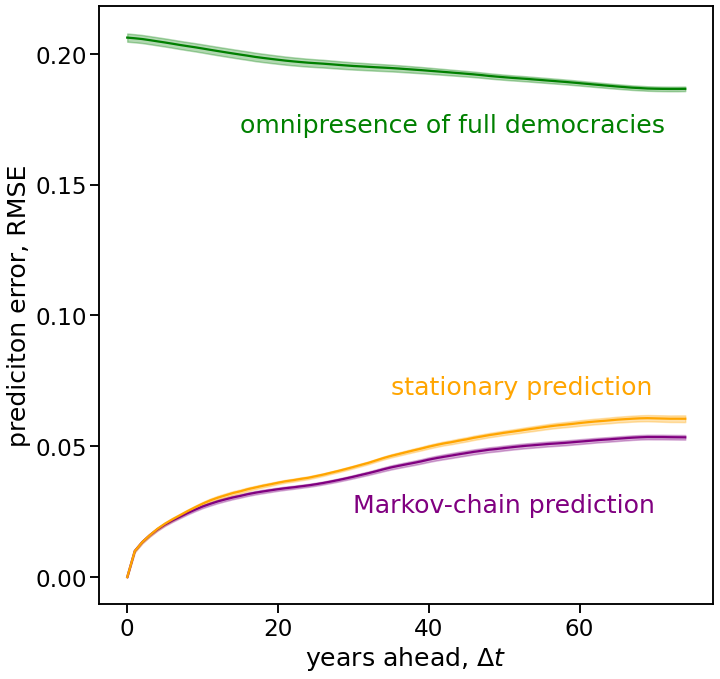

In [33]:
# def plotWithErrorShade(y,color='k'):
    
#     n = errorOut.shape[0]
    
#     mean = np.nanmean(y,axis=0)
#     std = np.nanstd(y,axis=0)/np.sqrt(n)
#     x = np.arange(0,len(mean))
    
#     plt.plot(x, mean, '-',color=color)
#     plt.fill_between(x, mean-std, mean+std,alpha=0.3,color=color)

# plt.figure(figsize=(11,11))  
# plotWithErrorShade(errorOut,color='purple')
# plotWithErrorShade(errorOutStationary,color='orange')

# plotWithErrorShade(errorOutEoH,color='green')


# plt.text(x=15,y=0.17,s='omnipresence of full democracies',color='green')
# plt.text(x=30,y=0.025,s='Markov-chain prediction',color='purple')
# plt.text(x=35,y=0.07,s='stationary prediction',color='orange')


# plt.ylabel('prediciton error, RMSE')
# plt.xlabel(r'years ahead, $\Delta t$')
# plt.savefig('./../results/figures/Fig7-predictionRMSE.pdf')
